# Kodex200 주식투자전략

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import bt
import datetime as dt
from tqdm import tqdm
import warnings
from matplotlib import gridspec
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
end_date = '2023-02-28'

## Data Loading

### Kodex200 Data Loading

In [3]:
#[kodex200.index[0] : end_date]

In [4]:
kodex200 = fdr.DataReader('069500').Close # Kodex200 069500    #Tiger200 102110
kodex200 = kodex200.loc['2017':'2022']
long = pd.DataFrame(kodex200)
long = long.loc['2017':'2022']

### Kospi Data Loading

In [5]:
kospi = fdr.DataReader('KS11').Close
kospi = kospi.dropna()
kospi = kospi.loc['2017':'2022']

### CD91(Risk Free) Data Loading

In [6]:
cd91 = pd.read_excel('merge.xlsx', sheet_name = 'cd91')
cd91.columns = ['Date', 'rf_rate']
cd91 = cd91.iloc[13:, :]
cd91['rf_rate'] = cd91['rf_rate'].astype('float64')
cd91 = cd91.set_index('Date')
cd91['rf_rate'] = cd91['rf_rate'] / 100
cd91 = cd91.loc['2017':'2022']

### VKOSPI Data Loading

In [7]:
vkospi = pd.read_excel('merge.xlsx', sheet_name = 'vkospi')
vkospi.columns = ['Date', '종가']
vkospi = vkospi.iloc[13:, :]
vkospi = vkospi.set_index('Date')
vkospi = vkospi.dropna()
vkospi = vkospi.loc['2017':'2022']

### S&P500 Data Loading

In [8]:
# sp500 = fdr.DataReader('US500').Close
# sp500_120ma = sp500.rolling(window = 120).mean()
# sp500_disparity = sp500 / sp500_120ma
# sp500_disparity = sp500_disparity.dropna()
# sp500_disparity = np.round(sp500_disparity * 100, 2)
# sp500_disparity = pd.DataFrame(sp500_disparity)
# #sp500_disparity = sp500_disparity.loc[kodex200.index[0]:]
# sp500_disparity['SP500_BuySell'] = 0

### NASDAQ Data Loading

In [9]:
# nasdaq = fdr.DataReader('IXIC').Close
# nasdaq_120ma = nasdaq.rolling(window = 120).mean()
# nasdaq_disparity = nasdaq / nasdaq_120ma
# nasdaq_disparity = nasdaq_disparity.dropna()
# nasdaq_disparity = np.round(nasdaq_disparity * 100, 2)
# nasdaq_disparity = pd.DataFrame(nasdaq_disparity)
# nasdaq_disparity['NASDAQ_BuySell'] = 0

## 분석에 쓰이는 함수

### 마지막 날 잡아내는 함수

In [10]:
def getDatelist(data, n, type=None):
    
    data.index.name='date'
    data=pd.DataFrame(data)
    date_list = data[[data.columns[0]]].copy()  # 첫번째 종목 가져오기(날짜는 어차피 다 같으므로)
    date_list.loc[date_list.index, 'm'] = date_list.index.month  # month date_list를 열로 생성
    date_list.loc[date_list.index, 'y'] = date_list.index.year  # 연도에 대한 date_list를 열로 생성
    
    if n < 29 : #n이 29일보다 작으면
        date_list = date_list[date_list.index.day >= n].reset_index()  # date_list의 day가 n일보다 크거나 같은 것만 가져와서
        date_list = date_list.groupby(['y', 'm']).nth(0).reset_index()  # groupby로 묶어서 맨 첫번째 있는 것만 가져와서
        date_list = pd.to_datetime(date_list['date'].dt.strftime('%Y-%m-%d'))  # list를 dt로 바꿔서
        date_list = data[data.isin(data.loc[date_list]).shift(0)].dropna(how='all').index  # data에 있는 아이들을 리스트를 가져온다.
        
    else: #n이 29 보다 같거나 크면
        date_list = date_list[date_list.index.day <= n].reset_index() # date_list의 day가 n일 보다 작거나 같은 것만 가져와서
        date_list = date_list.groupby(['y', 'm']).nth(-1).reset_index()  # groupby로 묶어서 맨 마지막 값만 가져와서
        date_list = pd.to_datetime(date_list['date'].dt.strftime('%Y-%m-%d'))  # list를 dt로 바꿔서
        date_list = data[data.isin(data.loc[date_list]).shift(0)].dropna(how='all').index  # data에 있는 아이들을 리스트를 가져온다.
    
    return date_list

### Begin and End Date

In [11]:
end_date_for_weight = getDatelist(long, 32)
begin_date_for_weight = getDatelist(long, 1)

### 전체 기간동안의 결과

In [12]:
def result(data, weight):
    
    st_ = bt.Strategy('',
        [   bt.algos.RunOnDate(*weight.index), # 리밸런싱 주기
            bt.algos.WeighTarget(weight), #비중 어케 할래
            bt.algos.Rebalance() # 리밸런싱해 
        ])

    btbtbt= bt.Backtest(st_, data, initial_capital = 100000.0, integer_positions = False, commissions=lambda q, p: max(1, abs(q) * 0.0014))
    r_bt = bt.run(btbtbt)
    
    output = r_bt.stats.loc[['total_return', 'cagr', 'max_drawdown']]
    output = output.astype('float32')
    output = np.round(output * 100, 2).astype('str') + '%'
    # output
    
    return np.ravel(output.values, order='C')

In [13]:
def result_once(data):
    
    st_ = bt.Strategy('',
        [   bt.algos.RunOnce(), # 리밸런싱 주기
            bt.algos.SelectAll(), #자산군 선택
            bt.algos.WeighEqually(), #비중 어케 할래
            bt.algos.Rebalance() # 리밸런싱해
        ])
    
    btbtbt= bt.Backtest(st_, data, initial_capital = 100000.0, integer_positions = False, commissions=lambda q, p: max(1, abs(q) * 0.0014))
    r_bt = bt.run(btbtbt)
    
    output = r_bt.stats.loc[['total_return', 'cagr', 'max_drawdown']]
    output = output.astype('float32')
    output = np.round(output * 100, 2).astype('str') + '%'
    
    return output

### 전체 기간동안의 그래프

In [14]:
def graph(data, title):
    
    fig, ax1 = plt.subplots(figsize = (90,30))
    color_1 = 'tab:red' ; color_2 = 'blue'
    c1 = ax1.plot((data).loc['2018':'2022', ], color = color_1, label = 'Portfolio')
    ax1.set_ylabel('Portfolio', fontsize=50)
    ax1.tick_params(axis='y', labelcolor='black', labelsize=50)
    
    plt.xticks(fontsize = 55)
    plt.title(title, fontsize = 55)
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('KOSPI', fontsize=50)
    ax2.tick_params(axis='y', labelcolor='black', labelsize=50)

    c2 = ax2.plot(pd.DataFrame(kospi['2018' : '2022']), color = color_2, label = 'KOSPI')
    c = c1 + c2
    ax1.legend(c, ['Portfolio', 'KOSPI'], loc = 'upper left', fontsize = 50)

### Kospi Rolling Result

In [15]:
def kospi_rolling(data, period):
    
    kospi_total_ret = [] ; kospi_cagr = [] ; kospi_mdd = []

    for i in (range(500)):

        a = begin_date_for_weight[12+i] 
        b = end_date_for_weight[12+period+i]    #  1년일땐 11, 2년일땐 23, 3년일땐 35

        if b == end_date_for_weight[-1]:

            sub_data = data.loc[a:b]

            st = bt.Strategy('',
            [   bt.algos.RunOnce(), # 리밸런싱 주기
                bt.algos.SelectAll(), #자산군 선택
                bt.algos.WeighEqually(), #비중 어케 할래
                bt.algos.Rebalance() # 리밸런싱해
            ],)

            btbtbt = bt.Backtest(st, pd.DataFrame(sub_data), initial_capital = 100000.0, integer_positions = False, commissions=lambda q, p: max(1, abs(q) * 0.0014))
            r_bt = bt.run(btbtbt)

            kospi_total_ret.append(r_bt.stats.loc['total_return'].values[0])
            kospi_cagr.append(r_bt.stats.loc['cagr'].values[0])
            kospi_mdd.append(r_bt.stats.loc['max_drawdown'].values[0])

            break

        else:

            sub_data = data.loc[a:b]

            st = bt.Strategy('',
            [   bt.algos.RunOnce(), # 리밸런싱 주기
                bt.algos.SelectAll(), #자산군 선택
                bt.algos.WeighEqually(), #비중 어케 할래
                bt.algos.Rebalance() # 리밸런싱해
            ],)

            btbtbt = bt.Backtest(st, pd.DataFrame(sub_data), initial_capital = 100000.0, integer_positions = False, commissions=lambda q, p: max(1, abs(q) * 0.0014))
            r_bt = bt.run(btbtbt)

            kospi_total_ret.append(r_bt.stats.loc['total_return'].values[0])
            kospi_cagr.append(r_bt.stats.loc['cagr'].values[0])
            kospi_mdd.append(r_bt.stats.loc['max_drawdown'].values[0])
            
    return [np.mean(kospi_total_ret), np.mean(kospi_cagr), np.mean(kospi_mdd)]

### Portfolio Rolling Result

In [16]:
def portfolio_rolling(data, weight, period):
    
    kodex200_total_ret = [] ; kodex200_cagr = [] ; kodex200_mdd = []

    for i in (range(500)):

        a = begin_date_for_weight[12+i]
        b = end_date_for_weight[12+period+i]  # 1년일땐 11, 2년일땐 23, 3년일땐 35

        if b == end_date_for_weight[-1]:

            sub_data = data.loc[a:b]
            sub_weight = weight.loc[a:b]

            st = bt.Strategy('',
            [   bt.algos.RunOnDate(*sub_weight.index), # 리밸런싱 주기
                bt.algos.WeighTarget(sub_weight), #비중 어케 할래
                bt.algos.Rebalance() # 리밸런싱해 
            ])

            btbtbt = bt.Backtest(st, sub_data, initial_capital = 100000.0, integer_positions = False, commissions=lambda q, p: max(1, abs(q) * 0.0014))
            r_bt = bt.run(btbtbt)

            kodex200_total_ret.append(r_bt.stats.loc['total_return'].values[0])
            kodex200_cagr.append(r_bt.stats.loc['cagr'].values[0])
            kodex200_mdd.append(r_bt.stats.loc['max_drawdown'].values[0])

            break

        else:

            sub_data = data.loc[a:b]
            sub_weight = weight.loc[a:b]

            st = bt.Strategy('',
            [   bt.algos.RunOnDate(*sub_weight.index), # 리밸런싱 주기
                bt.algos.WeighTarget(sub_weight), #비중 어케 할래
                bt.algos.Rebalance() # 리밸런싱해 
            ])

            btbtbt = bt.Backtest(st, sub_data, initial_capital = 100000.0, integer_positions = False, commissions=lambda q, p: max(1, abs(q) * 0.0014))
            r_bt = bt.run(btbtbt)

            kodex200_total_ret.append(r_bt.stats.loc['total_return'].values[0])
            kodex200_cagr.append(r_bt.stats.loc['cagr'].values[0])
            kodex200_mdd.append(r_bt.stats.loc['max_drawdown'].values[0])
        
    return [np.mean(kodex200_total_ret)*100, np.mean(kodex200_cagr)*100, np.mean(kodex200_mdd)*100]

In [17]:
def result_rolling_fund(data1, data2):
    
    output = pd.DataFrame([data1, data2], index = ['Portfolio', 'Kospi'], columns = ['Total_ret', 'CAGR', 'MDD'])
    output = np.round(output * 100, 2).astype('str') + '%'
    
    return output

In [18]:
def back_test(data, weight):
    
    st_ = bt.Strategy('',
        [   bt.algos.RunOnDate(*weight.index), # 리밸런싱 주기
            bt.algos.WeighTarget(weight), #비중 어케 할래
            bt.algos.Rebalance() # 리밸런싱해
        ])

    btbtbt = bt.Backtest(st_, data, initial_capital = 100000.0, integer_positions = False)
    r_bt = bt.run(btbtbt)
    
    return r_bt.prices

## Step1. 모멘텀 전략만을 사용했을 때

In [19]:
# 평균 모멘텀(월간)

def momentum_score(data, period, hurdle):
    
    df = pd.DataFrame(index = end_date_for_weight)
    df['Close'] = 0
    
    for i in range(period):
        
        df = df + (long.loc[end_date_for_weight].pct_change(i+1) > hurdle) * 1
    
    df = df / period
    
    return df

In [20]:
def only_momentum(data, total_weight, period, hurdle):
    
    long = pd.DataFrame(data)
    end_date_for_weight = getDatelist(long, 32)
    begin_date_for_weight = getDatelist(long, 1)
    
    mom = momentum_score(long, period, hurdle)
    weight = mom * total_weight
    weight = pd.DataFrame(weight, columns = ['Close'])
    weight['Cash'] = 1 - weight['Close']
#     weight = weight.iloc[:-1,:]
#     weight.index = begin_date_for_weight[1:]
    
    long2 = long.copy()
    long2['Cash'] = cd91['rf_rate'] / 252
    long2['Cash'] = (1 + long2['Cash']).cumprod()

    long2.columns = ['Close', 'Cash']
    long2.dropna(inplace = True)
    
    return long2, weight

## Step2. 모멘텀 전략과 박스권 전략을 병행하였을 때

### Box권 전략

In [21]:
def box_weight(data, upper, lower, split_upper, split_lower, invest_weight):
    buy_check_empty = [] ; sell_check_empty = []
    empty = [] ; price_empty = []
    datelist_end_date = getDatelist(data, 32)
    weight2 = pd.DataFrame(index = data.index, columns = ['now'])
    last_weight = 0 ; buy_check = 0 ; sell_check = 0 
    
    for j in range(len(datelist_end_date)-1):   # 한 달 조각에 대해 for문 돌리는 것

        price = data.loc[datelist_end_date[j]]
        price_empty.append(price)
        lower_hurdle = price * (1 - np.arange(split_upper, upper + 0.01, 0.01))
        upper_hurdle = price * (1 + np.arange(split_upper, upper + 0.01, 0.01))

        kospi_upper_bound1 = price * (1+upper)
        kospi_upper_bound2 = price * (1+split_upper)
        kospi_lower_bound1 = price * (1-split_lower)
        kospi_lower_bound2 = price * (1-lower)

        weight = pd.DataFrame(data.loc[datelist_end_date[j] : datelist_end_date[j+1]])
        weight['now'] = last_weight # 기존에 갖고 있던 비중을 그대로 가져감
        #weight['now'] = 0 # 기존 비중 털어버리고 다시 시작
        
        # 여기 바이 체크 셀 체크 있던 자리임
        
        empty.append(datelist_end_date[j])

        for i in range(len(weight.index)): # Weight라는 조각에 대해 for문 돌리는 것

            buy_point = sum(lower_hurdle >= weight.iloc[i,0]) # 매수 점수
            sell_point = sum(upper_hurdle <= weight.iloc[i,0]) # 매도 점수
            buy_check_empty.append(buy_check) ; sell_check_empty.append(sell_check)
            
            if (kospi_lower_bound2 < weight.iloc[i,0]) & (weight.iloc[i,0] <= kospi_lower_bound1) & \
            (weight.iloc[i-1,1] <= (1-invest_weight)):
                if (buy_point > buy_check):
                    if invest_weight*(buy_point-buy_check) > (1 - weight.iloc[i-1,1]):
                        weight.iloc[i,1] = 1
                        buy_check = buy_point
                    else:
                        weight.iloc[i,1] = weight.iloc[i-1,1] + invest_weight*(buy_point-buy_check) # 매집구간에 들어온 경우
                        buy_check = buy_point
                else:
                    weight.iloc[i,1] = weight.iloc[i-1,1]

            elif (weight.iloc[i,0] <= kospi_lower_bound2):
                weight.iloc[i,1] = 0 ; price1 = weight.iloc[i,0] ; price_empty.append(price1)
                
                kospi_upper_bound1 = price1 * (1 + upper)
                kospi_upper_bound2 = price1 * (1 + split_upper)
                kospi_lower_bound1 = price1 * (1 - split_lower)
                kospi_lower_bound2 = price1 * (1 - lower)
                
                lower_hurdle = price1 * (1 - np.arange(split_upper, upper + 0.01, 0.01))
                upper_hurdle = price1 * (1 + np.arange(split_upper, upper + 0.01, 0.01))
                buy_check = 0 ; sell_check = 0 ; empty.append(weight.index[i])

            elif (weight.iloc[i,0] >= kospi_upper_bound2) & (weight.iloc[i,0] < kospi_upper_bound1) & \
            (weight.iloc[i-1,1] >= invest_weight):
                
                if (sell_point > sell_check):
                    if invest_weight*(sell_point-sell_check) > (weight.iloc[i-1,1]):
                        weight.iloc[i,1] = 0
                        sell_check = sell_point
                    else:
                        weight.iloc[i,1] = weight.iloc[i-1,1] - invest_weight*(sell_point-sell_check)
                        sell_check = sell_point

                else:
                    weight.iloc[i,1] = weight.iloc[i-1,1]

            elif (weight.iloc[i,0] >= kospi_upper_bound1):
                weight.iloc[i,1] = 0 ; price2 = weight.iloc[i,0] ; price_empty.append(price2)
                
                kospi_upper_bound1 = price2 * (1 + upper)
                kospi_upper_bound2 = price2 * (1 + split_upper)
                kospi_lower_bound1 = price2 * (1 - split_lower)
                kospi_lower_bound2 = price2 * (1 - lower)
                
                lower_hurdle = price2 * (1 - np.arange(split_upper, upper + 0.01, 0.01))
                upper_hurdle = price2 * (1 + np.arange(split_upper, upper + 0.01, 0.01))
                buy_check = 0 ; sell_check = 0 ; empty.append(weight.index[i])
                
            else:
                weight.iloc[i,1] = weight.iloc[i-1,1] # 별 이상 없으면 그 전꺼 사용

        weight2.loc[weight.index] = pd.DataFrame(weight['now']) # weight 에 추가한 일일 비중을 원래 전체 데이터 프레임에 덮은 것
        last_weight = weight2['now'].loc[datelist_end_date[j+1]] #datelist_end_date에 찍힌 마지막 비중

    weight2.dropna(inplace=True)
    weight2.columns=['Close']
    
    return weight2, empty, price_empty

### 모멘텀 전략과 박스권 전략을 병행한 결과

In [22]:
def long_box_strategy(data, vol_data, box_hurdle, total_weight, box_weight, period, mom_hurdle):
    
    long = pd.DataFrame(data)
    end_date_for_weight = getDatelist(data, 32) # 원래는 data
    begin_date_for_weight = getDatelist(data, 1) # 원래는 data
    
    mom = momentum_score(long, period, mom_hurdle)
    box_box = vol_data.loc[end_date_for_weight]
    weight = mom * total_weight
    weight['box'] = 0
    
    for date in box_box['2002':].index:
    
        if (box_box.loc[date]['종가'] < box_hurdle) and (box_box.loc[date]['종가'] > 0):
            weight['box'].loc[date] = 0.9 * box_weight #박스권이면 비중 1, 박스권이 아니면 비중 0
            weight['Close'].loc[date] = 0 #박스권이니까 기존 비중을 죽임

        else:
            weight['box'].loc[date] = 0
            
    for date in weight.index:
    
        if weight['Close'].loc[date] >= 0:
            weight['Cash'] = 1 - weight[['Close','box']].sum(axis=1) 
            
#     weight = weight.iloc[:-1,:]
#     weight.index = begin_date_for_weight[1:]
    
    long2 = long.copy()
    long2 = pd.concat([long2, box_st], axis=1) #기존 Kodex200 지수와 박스권일때 만든 지수를 병합

    long2['Cash'] = cd91['rf_rate'] / 252
    long2['Cash'] = (1 + long2['Cash']).cumprod()

    long2.columns = ['Close','box','Cash']
    long2.dropna(inplace = True)
    
    return long2, weight

In [34]:
weight3, empty, price_empty = box_weight(kodex200, 0.1, 0.1, 0.05, 0.05, 1/10) #박스권일때 비중
box_st = back_test(long, weight3) # 박스권 지수

In [35]:
mom_hurdle = [0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02]
rolling_period = [11, 23, 35]
result_output = []

for j in tqdm(range(len(rolling_period))):

    for i in (range(len(mom_hurdle))):

        only_mom_df, only_mom_weight_df = only_momentum(kodex200, 0.9, 6, mom_hurdle[i])
        long_box_df, long_box_weight_df = long_box_strategy(kodex200, vkospi, 18.5, 0.9, 1, 6, mom_hurdle[i])

        result_output.append(np.round(portfolio_rolling(only_mom_df, only_mom_weight_df, rolling_period[j]), 2))
        result_output.append(np.round(portfolio_rolling(long_box_df, long_box_weight_df, rolling_period[j]), 2))


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:45<00:00, 75.27s/it]


In [37]:
pd.DataFrame(result_output)

,0,1,2
0,5.21,5.24,-8.09
1,7.07,7.11,-6.47
2,5.59,5.63,-7.62
3,6.76,6.81,-6.48
4,4.73,4.76,-7.74
5,6.10,6.14,-6.48
6,4.92,4.95,-7.46
7,6.15,6.19,-6.48
8,5.06,5.09,-7.27
9,6.10,6.14,-6.43


In [26]:
stop

NameError: name 'stop' is not defined

In [ ]:
# mom_hurdle = [0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02]
# result_output = []

# for i in tqdm(range(len(mom_hurdle))):

#     only_mom_df, only_mom_weight_df = only_momentum(kodex200, 0.9, 6, mom_hurdle[i])
#     long_box_df, long_box_weight_df = long_box_strategy(kodex200, vkospi, 18.5, 0.9, 1, 6, mom_hurdle[i])

#     result_output.append(result(only_mom_df, only_mom_weight_df))
#     result_output.append(result(long_box_df, long_box_weight_df))

In [ ]:
result_once(pd.DataFrame(kospi))

In [ ]:
stop

In [ ]:
long_box_df, long_box_weight_df = long_box_strategy(kodex200, vkospi, 18.5, 0.9, 1, 6, 0.005)

In [ ]:
rolling_period = [11, 23, 35]
kospi_output = []

for j in tqdm(range(len(rolling_period))):

    kospi_output.append(np.round(kospi_rolling(kospi, rolling_period[j]), 4)*100)

In [ ]:
pd.DataFrame(kospi_output)

In [ ]:
ads

In [ ]:
only_mom_df, only_mom_weight_df = only_momentum(kodex200, 0.9, 6, 0.005)

In [38]:
weight3, empty, price_empty = box_weight(kodex200, 0.08, 0.08, 0.04, 0.04, 1/10) #박스권일때 비중
box_st = back_test(long, weight3) # 박스권 지수
long_box_df, long_box_weight_df = long_box_strategy(kodex200, vkospi, 18.5, 0.9, 1, 6, 0.005)

In [39]:
kospi = kospi.loc['2018':'2022']
kospi = kospi / kospi[0] * 100

In [40]:
x = back_test(long_box_df, long_box_weight_df)
x = x.loc['2018':'2022']
x = x / x.iloc[0,0] * 100

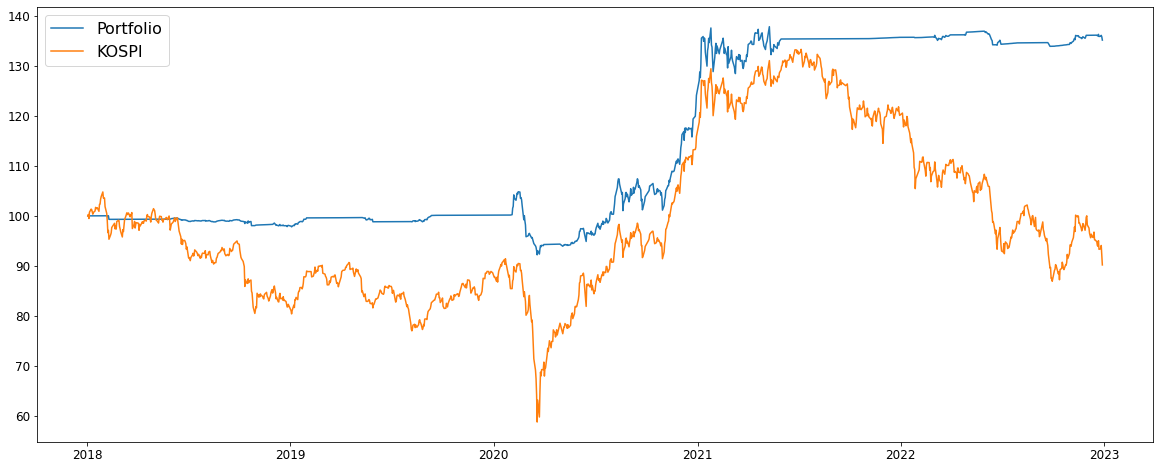

In [41]:
plt.figure(figsize=(20,8))
plt.plot(x, label='Portfolio')
plt.plot(kospi, label='KOSPI')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(loc='upper left', fontsize = 16)

In [ ]:
graph(back_test(long_box_df, long_box_weight_df), '최근 5년, 기준선 0.5%')

In [ ]:
result_once(pd.DataFrame(kospi))

In [ ]:
kospi_month_df = kospi.loc[end_date_for_weight]
kospi_month_df = kospi_month_df.loc['2017-12':]
kospi_month_ret_df = kospi_month_df.pct_change()
kospi_month_ret_df = kospi_month_ret_df.dropna()

In [ ]:
ret_list = [0.005, 0.006, 0.007, 0.008, 0.009, 0.01]

for i in range(len(ret_list)):
    
    num = sum(kospi_month_ret_df > ret_list[i])
    print("{}%보다 수익률이 높았던 횟수는 전체 {}번 중에서 {}번({}%) 입니다.".format(np.round(ret_list[i]*100, 1), \
                                                               len(kospi_month_ret_df), num, int(num/len(kospi_month_ret_df)*100)))

In [ ]:
(1.0521)**(1/12)

In [ ]:
result(only_mom_df, only_mom_weight_df)

In [ ]:
only_mom_df, only_mom_weight_df = only_momentum(kodex200, 0.9, 6, mom_hurdle[i])
long_box_df, long_box_weight_df = long_box_strategy(kodex200, vkospi, 18.5, 0.9, 0.9, 6, mom_hurdle[i])

In [ ]:
stop

## Step3. Risk Management

### S&P500과 NASDAQ을 이용한 주식 포지션 조절 방법

- 나스닥 지수 120일 이동평균(최근 데이터에 가중치)
- 전날 이격도가 94%보다 높은 상태에서 오늘 종가가 94%이하로 떨어진 경우 매도 시그널
- S&P500, NASDAQ에서 모두 매도시그널이 포착되면 그 날짜에 대한 비중은 모두 현금 100%로 수정

In [ ]:
def control_risk(sp500, nasdaq, down, up):
    
    sp500_copy = sp500.copy()
    nasdaq_copy = nasdaq.copy()
    
    for i in range(len(sp500_copy)-1):
    
        if (sp500_copy.iloc[i, 0] > down) and (sp500_copy.iloc[i+1, 0] <= down):
            sp500_copy['SP500_BuySell'][i+1] = -1
        elif (sp500_copy.iloc[i, 0] < up) and (sp500_copy.iloc[i+1, 0] >= up):
            sp500_copy['SP500_BuySell'][i+1] = 1
        else:
            pass
        
    for i in range(len(nasdaq_copy)-1):
    
        if (nasdaq_copy.iloc[i, 0] > down) and (nasdaq_copy.iloc[i+1, 0] <= down):
            nasdaq_copy['NASDAQ_BuySell'][i+1] = -1
        elif (nasdaq_copy.iloc[i, 0] < up) and (nasdaq_copy.iloc[i+1, 0] >= up):
            nasdaq_copy['NASDAQ_BuySell'][i+1] = 1
        else:
            pass
        
    total_df = pd.concat([sp500_copy[['Close', 'SP500_BuySell']], \
                           nasdaq_copy[['Close', 'NASDAQ_BuySell']]], axis = 1)
    total_df = total_df.dropna()
    total_df['BuySell'] = total_df['SP500_BuySell'] + total_df['NASDAQ_BuySell']
    total_df['BuySell'] = total_df['BuySell'].shift()
    total_df = total_df.loc[kodex200.index[0]:]
    
    sell_sign = total_df[(total_df['BuySell'] == -2) | (total_df['BuySell'] == -1)]
    sample = pd.DataFrame(index = sell_sign.index, columns = ['Close', 'box', 'Cash'])
    sample = pd.concat([long_box_weight_df, sample], ignore_index = False, axis=1)
    sample = sample.iloc[:, 0:3]
    
    for i in range(len(sell_sign)):
    
        if sum(sample.loc[sell_sign.index[i]]) > 0:

            if sell_sign['BuySell'][i] == -1:
                point = list(sample.index).index(sell_sign.index[i])
                sample.iloc[point, 0] = sample.iloc[point, 0] # 여기서 주식 비중을 줄이게 되면 전체 리턴이 줄어듬
                sample.iloc[point, 1] = sample.iloc[point, 1] 
                sample.iloc[point, 2] = sample.iloc[point, 2]

            else:
                point = list(sample.index).index(sell_sign.index[i])
                sample.iloc[point, 0] = 0
                sample.iloc[point, 1] = 0
                sample.iloc[point, 2] = 1

        else:

            if sell_sign['BuySell'][i] == -1:
                point = list(sample.index).index(sell_sign.index[i])
                sample.iloc[point, 0] = sample.iloc[point-1, 0]
                sample.iloc[point, 1] = sample.iloc[point-1, 1] 
                sample.iloc[point, 2] = sample.iloc[point-1, 2] 
                
            else:
                point = list(sample.index).index(sell_sign.index[i])
                sample.iloc[point, 0] = 0
                sample.iloc[point, 1] = 0
                sample.iloc[point, 2] = 1
    
    sample = sample.loc['2002-11':]
    
    return sample

In [ ]:
# down, up = 94, 100
# sp500_copy = sp500.copy()
# nasdaq_copy = nasdaq.copy()

# for i in range(len(sp500_copy)-1):

#     if (sp500_copy.iloc[i, 3] > down) and (sp500_copy.iloc[i+1, 3] <= down):
#         sp500_copy['SP500_BuySell'][i+1] = -1
#     elif (sp500_copy.iloc[i, 3] < up) and (sp500_copy.iloc[i+1, 3] >= up):
#         sp500_copy['SP500_BuySell'][i+1] = 1
#     else:
#         pass

# for i in range(len(nasdaq_copy)-1):

#     if (nasdaq_copy.iloc[i, 3] > down) and (nasdaq_copy.iloc[i+1, 3] <= down):
#         nasdaq_copy['NASDAQ_BuySell'][i+1] = -1
#     elif (nasdaq_copy.iloc[i, 3] < up) and (nasdaq_copy.iloc[i+1, 3] >= up):
#         nasdaq_copy['NASDAQ_BuySell'][i+1] = 1
#     else:
#         pass

# total_df = pd.concat([sp500_copy[['SP500_Close', 'SP500_Disparity', 'SP500_BuySell']], \
#                        nasdaq_copy[['NASDAQ_Close', 'NASDAQ_Disparity', 'NASDAQ_BuySell']]], axis = 1)
# total_df = total_df.dropna()
# total_df['BuySell'] = total_df['SP500_BuySell'] + total_df['NASDAQ_BuySell']
# #total_df['BuySell'] = total_df['BuySell'].shift()
# total_df = total_df.loc['2002-10-14':'2023-01-31']

# sell_sign = total_df[(total_df['BuySell'] == -2) | (total_df['BuySell'] == -1)]

In [ ]:
control_weight = control_risk(sp500_disparity, nasdaq_disparity, 94, 100)

In [ ]:
result(long_box_df, control_weight)

In [ ]:
result_rolling_fund(portfolio_rolling(long_box_df, control_weight), kospi_rolling(kospi))

In [ ]:
graph(back_test(long_box_df, control_weight), 'Mixed with Momentum, Box Strategy and Risk Management')

In [ ]:
control_weight

In [ ]:
asddads

In [ ]:
recent_df = long_box_df.loc[recent_weight.index[0] : recent_weight.index[-1]]

In [ ]:
recent_df

In [ ]:
recent_weight = long_box_weight_df.tail(13) ; recent_weight

In [ ]:
recent_weight.index[1]

In [ ]:
recent_df.loc[recent_weight.index[0] : recent_weight.index[1]]

In [ ]:
recent_df

In [ ]:
recent_weight.index[0].strftime('%Y-%m')

In [ ]:
long_box_weight_df

In [ ]:
recent_weight = long_box_weight_df.iloc[-13:-1, :]

In [ ]:
recent_weight

In [ ]:
temp_df

## 최근 1년 PT자료에 관한 코드

In [ ]:
recent_weight = long_box_weight_df.iloc[-13:-1, :]
recent_df = long_box_df.loc[recent_weight.index[0] : '2023-02-28']

portfolio_empty = []

for i in range(len(recent_weight)):
    
    temp_df = recent_df.loc[recent_weight.index[i].strftime('%Y-%m')]
    temp_result = result(temp_df, pd.DataFrame(recent_weight.iloc[i, :]).T).values
    temp_result = np.ravel(temp_result, order='C')
    portfolio_empty.append(temp_result)
    
#     if i == len(recent_weight)-2:
        
#         temp_df = recent_df.loc[recent_weight.index[i] : '2023-01-31']
#         temp_result = result_once(temp_df).values
#         temp_result = np.ravel(temp_result, order='C')
#         portfolio_empty.append(temp_result)

In [ ]:
portfolio_empty

In [ ]:
recent_weight = long_box_weight_df.iloc[-13:-1, :]
recent_kospi_df = pd.DataFrame(kospi.loc[recent_weight.index[0] : '2023-02-28'])

kospi_empty = []

for i in range(len(recent_weight)):
    
    temp_kospi_df = recent_kospi_df.loc[recent_weight.index[i].strftime('%Y-%m')]
    temp_kospi_result = result_once(temp_kospi_df).values
    temp_kospi_result = np.ravel(temp_kospi_result, order='C')
    kospi_empty.append(temp_kospi_result)


In [ ]:
recent_weight = long_box_weight_df.tail(12)
recent_kospi_df = pd.DataFrame(kospi.loc[recent_weight.index[0] : '2023-01-31'])

kospi_empty = []

for i in range(len(recent_weight)-1):
    
    temp_kospi_df = recent_kospi_df.loc[recent_weight.index[i] : recent_weight.index[i+1]]
    temp_kospi_result = result_once(temp_kospi_df).values
    temp_kospi_result = np.ravel(temp_kospi_result, order='C')
    kospi_empty.append(temp_kospi_result)
    
    if i == len(recent_weight)-2:
        
        temp_kospi_df = recent_kospi_df.loc[recent_weight.index[i] : '2023-01-31']
        temp_kospi_result = result_once(temp_kospi_df).values
        temp_kospi_result = np.ravel(temp_kospi_result, order='C')
        kospi_empty.append(temp_kospi_result)

In [ ]:
risk_management_weight = long_box_weight_df.loc['2021-07':'2022-01']

In [ ]:
risk_management_df = long_box_df.loc['2021-07':'2022-01']

In [ ]:
risk_management_empty = []

In [ ]:
for i in range(len(risk_management_weight)-1):
    
    risk_management_df = risk_management_df.loc[risk_management_weight.index[i] : risk_management_weight.index[i+1]]
    risk_management_result = result_once(temp_df).values
    risk_management_result = np.ravel(temp_result, order = 'C')
    risk_management_empty.append(temp_result)
    
    if i == len(risk_management_weight)-2:
        
        temp_df = recent_df.loc[recent_weight.index[i] : '2023-01-31']
        temp_result = result_once(temp_df).values
        temp_result = np.ravel(temp_result, order = 'C')
        risk_management_empty.append(temp_result)

In [ ]:
result(risk_management_df, control_weight.loc['2021-07':'2022-01'])

In [ ]:
risk_management_weight

In [ ]:
long_box_weight_df.loc['2023']

In [ ]:
portfolio_empty = pd.DataFrame(portfolio_empty, index = recent_weight.index, columns = ['Return', 'CAGR', 'MDD'])

In [ ]:
portfolio_empty

In [ ]:
kospi_empty = pd.DataFrame(kospi_empty, index = recent_weight.index, columns = ['Return', 'CAGR', 'MDD'])

In [ ]:
kospi_empty

In [ ]:
recent_vkospi = vkospi.loc[recent_weight.index[0] : '2023-01-31']

In [ ]:
recent_control_weight = control_weight.loc[recent_weight.index[0] : '2023-01-31']

In [ ]:
result(recent_df, control_weight)

In [ ]:
result(recent_df, recent_control_weight)

In [ ]:
f, axes = plt.subplots(2, 1)
f.set_size_inches((12, 8))
plt.subplots_adjust(wspace = 0.15, hspace = 0.25)

gs = gridspec.GridSpec(nrows=2, # row 몇 개 
                       ncols=1, # col 몇 개 
                       height_ratios=[1, 0.4], 
                      )

axes[0] = plt.subplot(gs[0])
axes[0].plot(recent_df['Close'], color = 'blue')
#axes[0].set_ylim([19000, 24000])
axes[0].set_title('Kodex200')

axes[1] = plt.subplot(gs[1])
axes[1].plot(recent_vkospi['종가'], color = 'black')
axes[1].set_ylim([10, 40])
axes[1].set_title('VKOSPI (Hurdle: 18.5)')
axes[1].axhline(y = 18.5, color = 'red')